# Splitting datasets into training and test

In this notebook, we are going to show how to split the entries of a dataset, along time, to construct training and test subsets of data (or training/validation/test). Specifically, we'll use the `split` function:

In [1]:
from gluonts.dataset.split import split

This needs to be given:

- the `dataset` that we want to split;
- an `offset` or a `date`, but not both simultaneously. These two arguments are provided for the function to know how to slice training and test data, based on a fixed integer offset or a ``pandas.Period``, respectively.

As a result, the `split` method returns the splited dataset, consisting of the training data `training_dataset` and a "test template" that knows how to generate input/output test pairs.

## Loading a dataset

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (20, 3)

For our examples, we will use data from the following `csv` file, which is originally sampled every 5 minutes, but we resample at hourly frequency. Note that this makes for a dataset consisting of a single time series, but everything we show here applies to any dataset, regardless of how many series it contains.

In [3]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = (
    pd.read_csv(url, header=0, index_col="timestamp", parse_dates=True)
    .resample("1H")
    .sum()
)

This is what the data looks like:

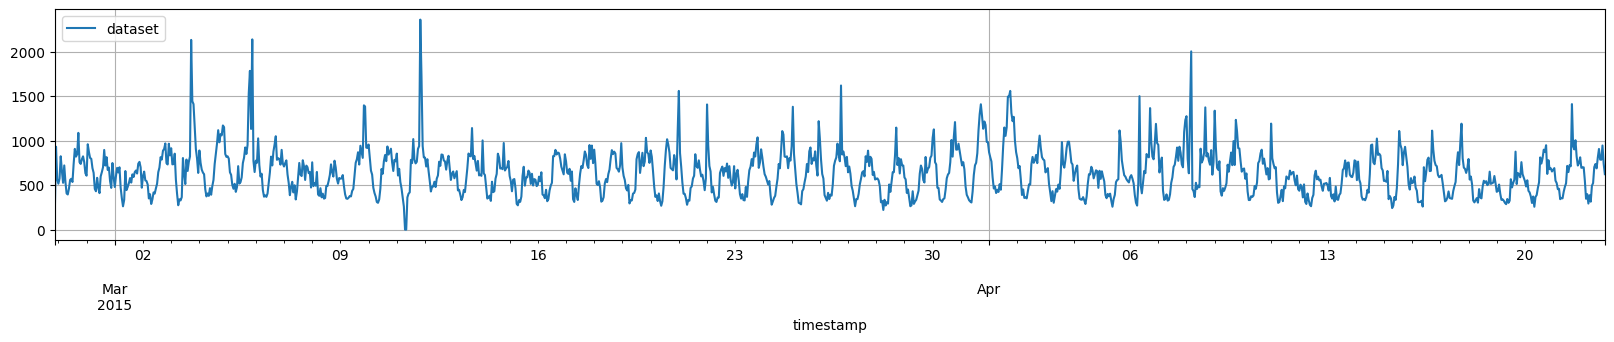

In [4]:
df.plot()
plt.legend(["dataset"], loc="upper left")
plt.show()

Turn the dataframe into a GluonTS dataset using `PandasDataset`

In [5]:
from gluonts.dataset.pandas import PandasDataset

dataset = PandasDataset(df, target="value")

## Train/test splits

Let's define a few helper functions to visualize data splits.

In [6]:
from gluonts.dataset.util import to_pandas


def highlight_entry(entry, color):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    plt.axvspan(start, end, facecolor=color, alpha=0.2)


def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(original_dataset, training_dataset):
        to_pandas(original_entry).plot()
        highlight_entry(train_entry, "red")
        plt.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in original_dataset:
        for test_input, test_label in test_pairs:
            to_pandas(original_entry).plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()

For the first example, we will take training data up to specific date, and then directly generate several test instances from the same date onwards.

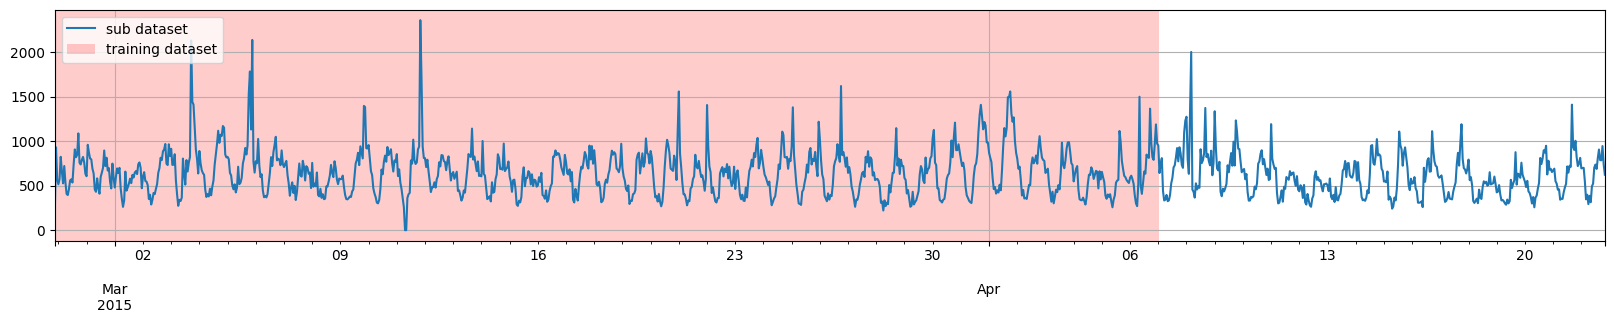

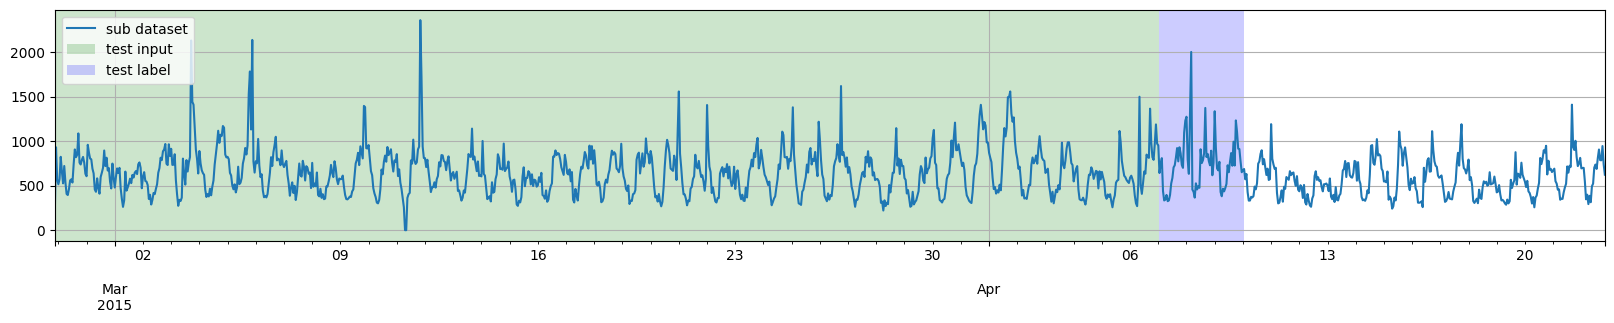

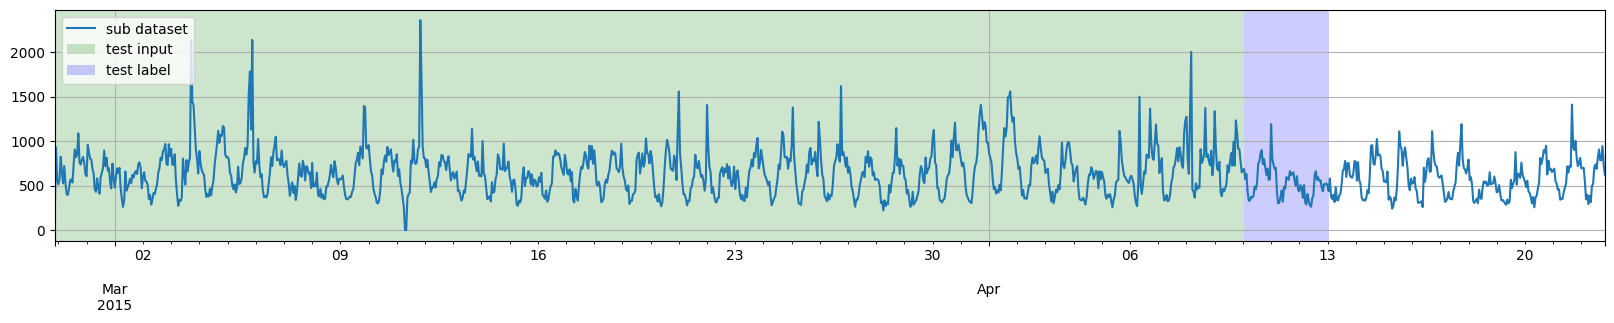

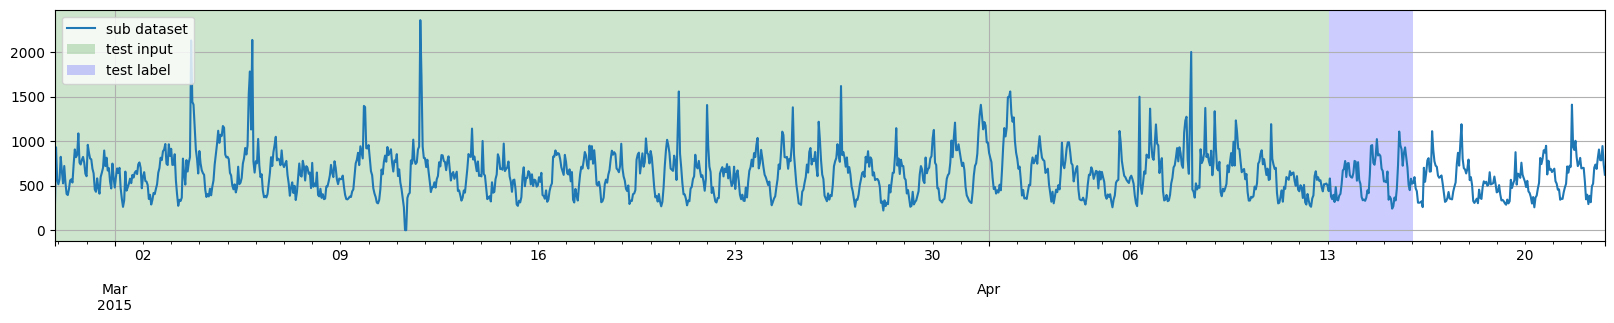

In [7]:
prediction_length = 3 * 24
training_dataset, test_template = split(
    dataset, date=pd.Period("2015-04-07 00:00:00", freq="1H")
)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=3,
)

plot_dataset_splitting(dataset, training_dataset, test_pairs)

However, we don't necessarily need to align the date where training data ends with the date where the testing part starts. So, for the second example, we will take training data up to date `2015-03-27 00:00:00`, then generate several test instances from date `2015-04-07 00:00:00` onwards by applying the `split` function two times.

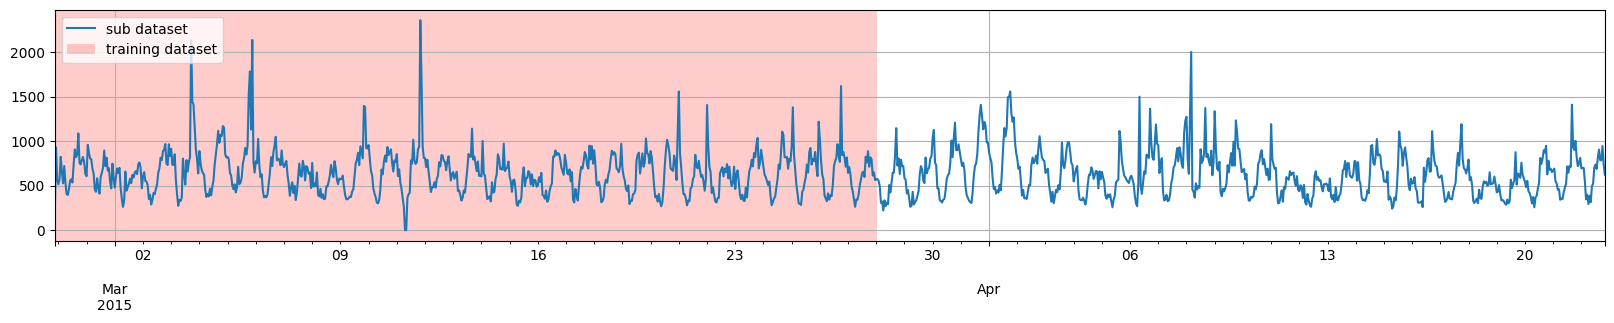

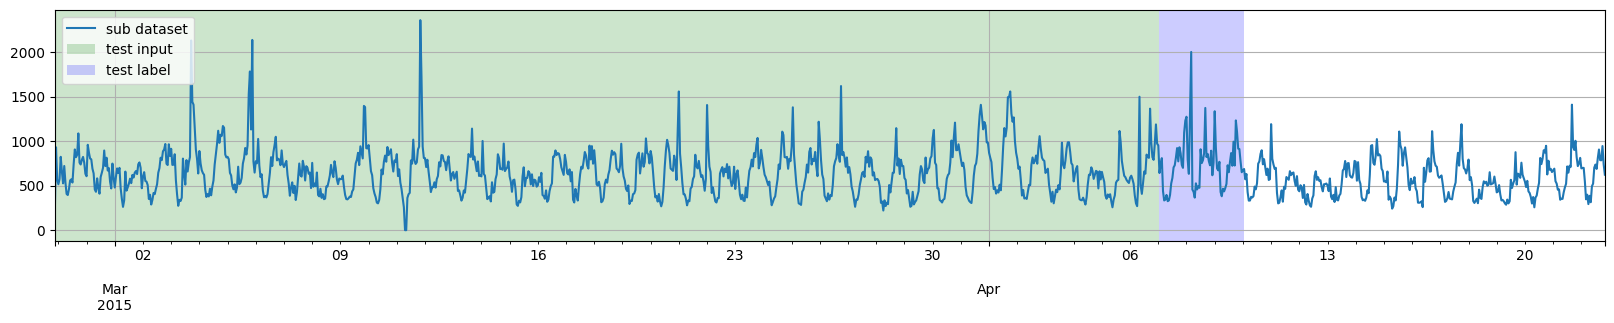

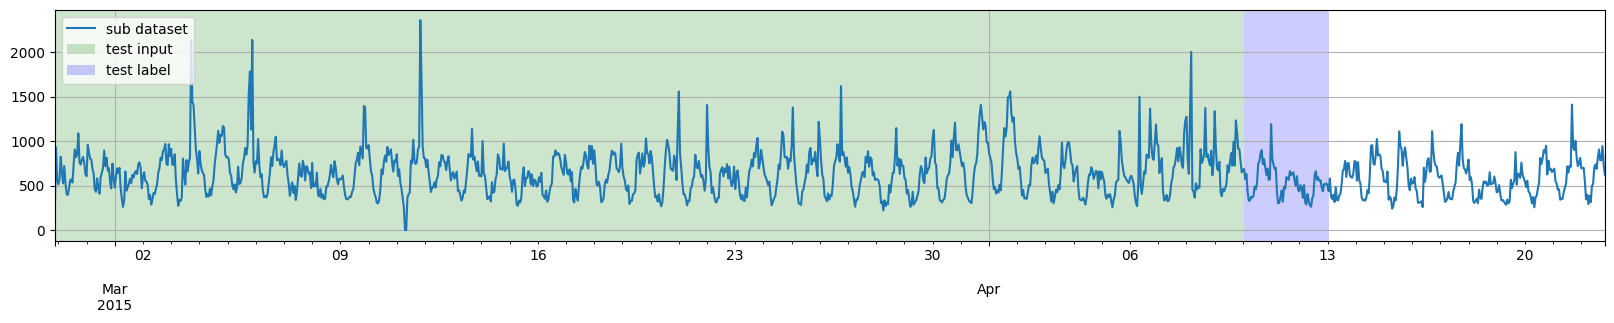

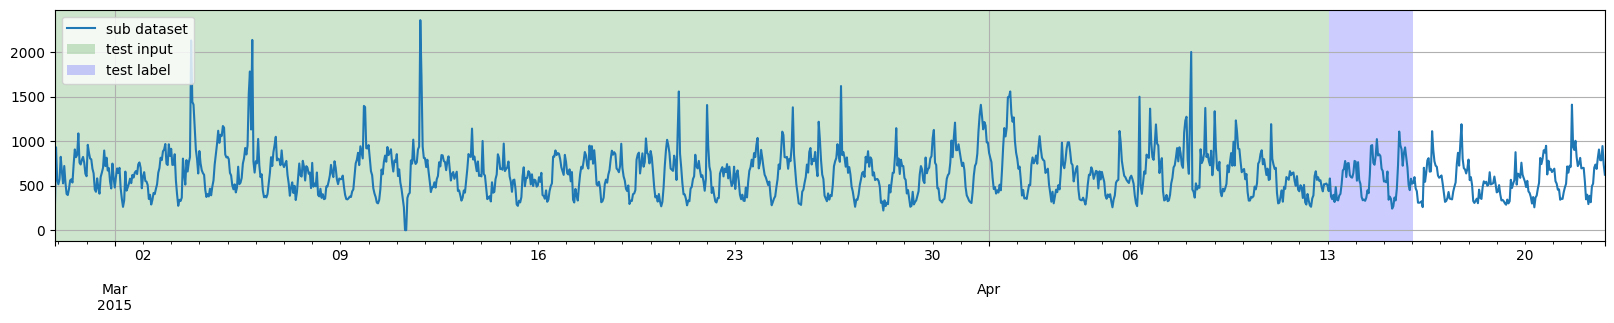

In [8]:
training_dataset, _ = split(dataset, date=pd.Period("2015-03-28 00:00:00", freq="1H"))
_, test_template = split(dataset, date=pd.Period("2015-04-07 00:00:00", freq="1H"))
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=3,
)

plot_dataset_splitting(dataset, training_dataset, test_pairs)

Also, we don't necessarily need to align all the test instances time by time. So, for the third example, we will add `distance` arguments in `generate_instances` function to make test instances overlap between each other.

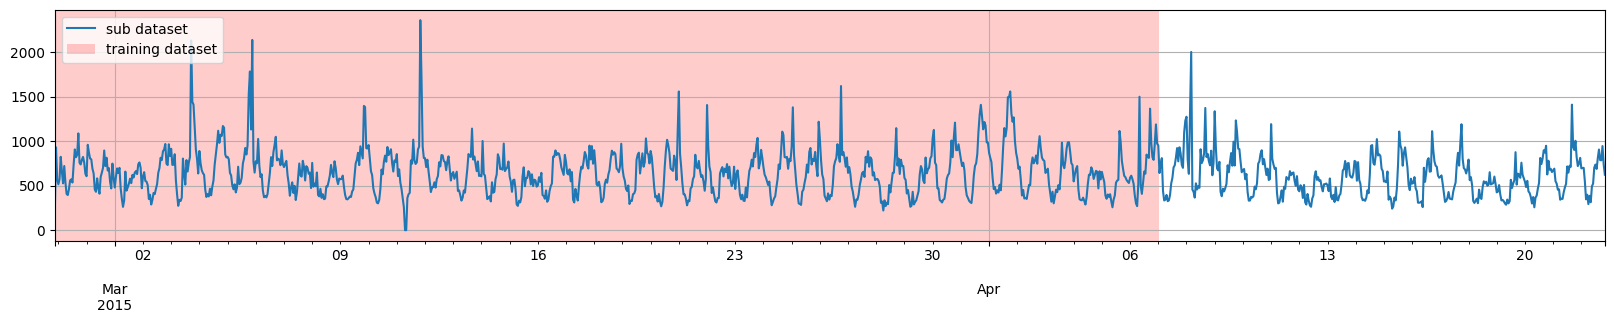

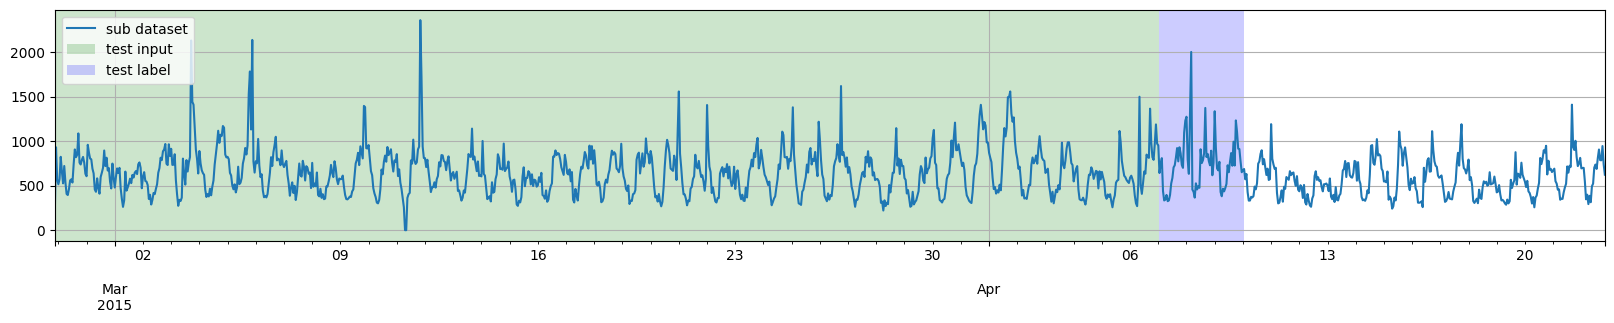

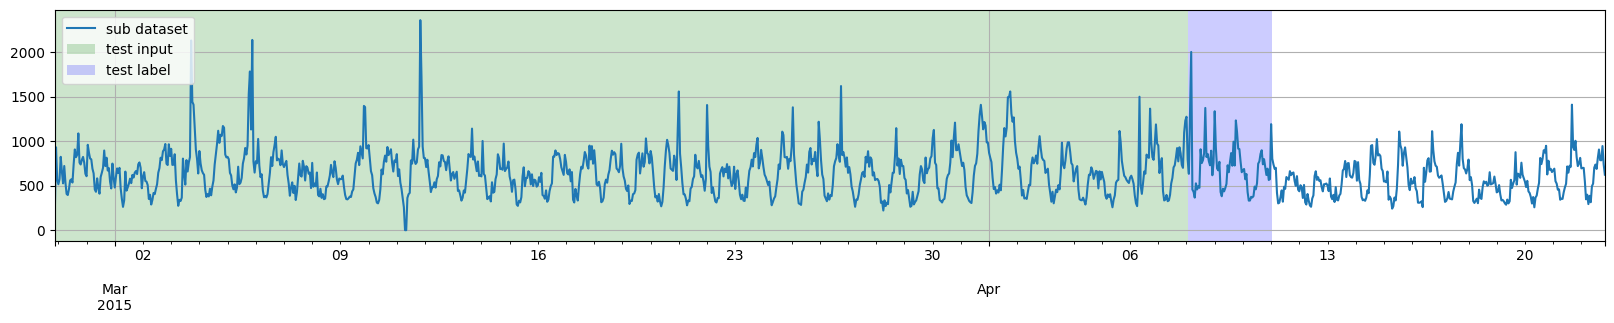

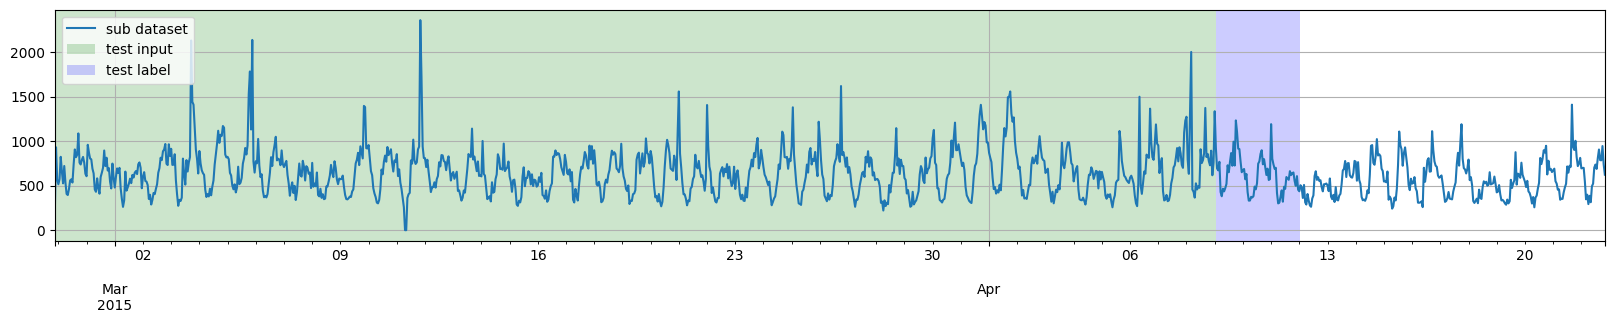

In [9]:
training_dataset, test_template = split(
    dataset, date=pd.Period("2015-04-07 00:00:00", freq="1H")
)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=3,
    distance=24,
)

plot_dataset_splitting(dataset, training_dataset, test_pairs)